# Eigen-Portfolio Construction
### Francisco A. Ibanez

## Part 1: Data
The data set is composed of closing prices of 11 ETFs available for trading in US exchanges. We chose using these securities over single stocks due to their high liquidity and accessibility, making this exercise easy to replicate by retail investors. In terms of asset classes, the set covers Equities, Rates, Credit and Commodities. The data is pulled from Yahoo Finance, and all these funds are quoted in US Dollars.

Given that these prices are in total return space, we first must subtract the cash component from their return. For this, we use the daily risk-free rate published on **Ken French's website**. In days for which we do not have a risk-free rate, we use the most recent value for the missing entry.

Given the length of the ETF data we are working with, the data set consists of observations extending from 4/30/2007 to 11/30/2021. Given that these ETFs are passive and benchmarked against an index, we might be able to extend their length by using the corresponding benchmark to backfill the data set in a future iteration. For now, we are restricting ourselves to use what is available.

Additionally, and for the sake of simplicity, we are dropping from the set rows (dates) with missing observations. In future work these missing observations will be estimated through other methods such as Markov Chain Monte Carlo.

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick
import seaborn as sns

# ETF prices
meta = pd.read_csv('etfs.csv', index_col=0)
collect = []
for n in meta.index:
    ticker = yf.Ticker(n)
    px = ticker.history(period="max")['Close']
    px.name = n
    collect += [px]

prices = pd.concat(collect, axis=1)

# Risk free rate (Fama-French)
ff = web.DataReader(
    'F-F_Research_Data_Factors_daily', 
    'famafrench',
    start='12/31/1999'
)
rf = ff[0]['RF'] * .01  # Originally expressed in percentage points

# Subtract the risk-free rate
total_return = prices.pct_change().dropna()
excess_return = total_return.sub(rf.reindex(total_return.index, method='ffill'), axis=0)

# Summary of the data set
data_summary = pd.DataFrame(index=meta.index)
data_summary['Name'] = meta['name']
data_summary['Asset class'] = meta['asset']
data_summary['Region'] = meta['region']
data_summary['Starting date'] = prices.apply(pd.Series.first_valid_index).sort_values()
data_summary['Ending date'] = prices.apply(pd.Series.last_valid_index).sort_values()
data_summary['Data points'] = prices.count()

data_summary

,Name,Asset class,Region,Starting date,Ending date,Data points
ticker,,,,,,
IVV,iShares Core S&P 500,Equities,United States,2000-05-19,2022-01-14,5450
EZU,iShares MSCI Eurozone,Equities,Europe,2000-07-31,2022-01-14,5401
EWU,iShares MSCI United Kingdom,Equities,Europe,1996-03-18,2022-01-14,6504
ILF,iShares Latin America 40,Equities,Emerging Markets,2001-10-26,2022-01-14,5091
EWJ,iShares MSCI Japan,Equities,Japan,1996-03-18,2022-01-14,6504
FXI,iShares China Large-Cap,Equities,Emerging Markets,2004-10-08,2022-01-14,4349
IAU,iShares Gold,Commodities,Precious Metals,2005-01-28,2022-01-14,4272
SLV,iShares Silver,Commodities,Precious Metals,2006-04-28,2022-01-14,3958
IEF,iShares 7-10 Year Treasury,Rates,United States,2002-07-30,2022-01-14,4902


## Part 2: Portfolio Diversification Framework
### 2.1 Measuring Diversification
From the correlation matrix below, we can draw the following observations:
1. Correlation between the equity related ETF, both US and non-US centric, is very high
2. Correlation between the bond related ETF (Rates and Credit) is very high
3. Credit is decently correlated to Equities

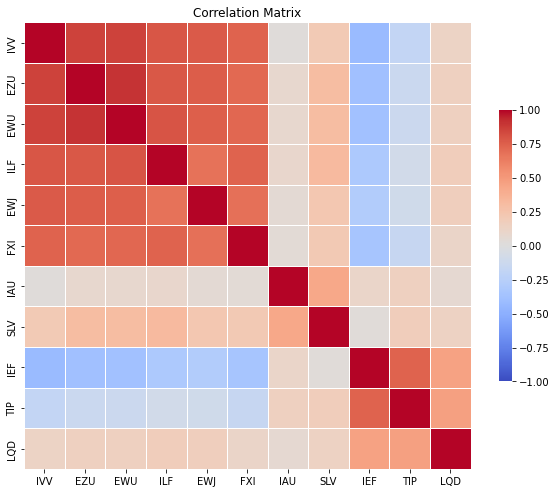

In [2]:
# Correlation matrix
R = excess_return.corr()
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Correlation Matrix')
sns.heatmap(R, linewidths=.5, cmap='coolwarm', vmax=1, vmin=-1, square=True, ax=ax, cbar_kws={'shrink': .5})
plt.show()

Despite the large and apparently diversified set of investable assets, it is natural to raise the question of how many bets this set contains, given the notorious correlation in the set. To shed some light on this question, we can diagonalize the risk model ($\Sigma$) by decomposing it into its eigen-values and eigen-vectors.

\begin{align}
\Sigma v & = \lambda v \\
\Sigma V & = V \Lambda \\
\Sigma & = V\Lambda V^{-1}
\end{align}

$$
\Lambda = \begin{bmatrix} 
\lambda_{1} & 0 & \dots & 0 \\ 
0 & \lambda_{2} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \dots & \lambda_{N} \\
\end{bmatrix}_{N \times N}  , \enspace
\mathbf{V} = \begin{bmatrix} 
\mid & \mid &  & \mid \\ 
v_{1} & v_{2} & \dots & v_{N} \\
\mid & \mid &  & \mid \\ 
\end{bmatrix}_{N \times N} 
$$

where the eigen-value $\lambda_{i}$ is the risk associated to the eigen-vector $v_{i}$. Because $trace(\Sigma) = trace(\Lambda)$, the percentage of "total risk" of this set of securities explained by the principal component $i$ will be given by: 

$$
\frac{\lambda_{i}}{trace(\Lambda)}
$$

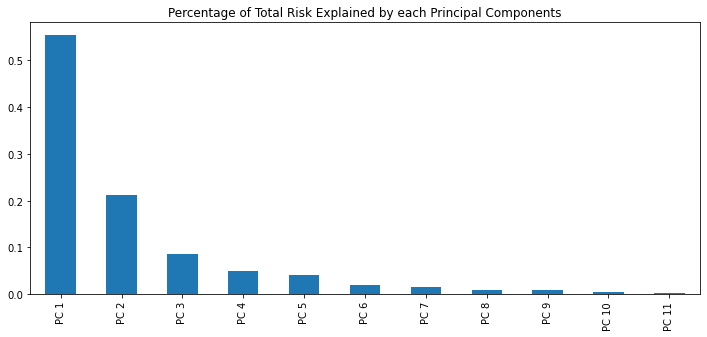

In [3]:
# We diagonalize Sigma into its eigen-vector and eigen-value matrices
Sigma = excess_return.cov().values # Variance-Covariance matrix
Lambda, V = np.linalg.eig(Sigma)
order = Lambda.argsort()[::-1]
Lambda = Lambda[order]
V = V[:, order]

# Percentage of "total risk" explained by each principal component
pct_of_risk = np.divide(Lambda, np.sum(Lambda))
pct_of_risk = pd.Series(pct_of_risk, index=[f'PC {str(x + 1)}' for x in range(len(V))])
pct_of_risk.plot.bar(figsize=(12, 5), title='Percentage of Total Risk Explained by each Principal Components')
plt.show()

The results below indicate that about **60% of the total risk in this set is coming just from the first principal component, while the first four principal components already explain more than 90% of the total variance**. Despite sourcing risk from different asset classes and across different global regions, we (often) arrive to very concentrated investment portfolios. This is due to the common misconception in the investment industry that diversification is coming from variety in names and labels (i.e. different securities, different markets, different asset class) instead of having an homogeneous risk loadings on the statistical factors (whatever they are) driving the returns of this set. The aim of successful portfolio construction should be to provide the right linear transformation (i.e. weights vector) that reduces the concentration of portfolio risk, in factor terms, within a given set of constraints.

For this reason, Meucci (2009) provides a framework for portfolio diversification in factor terms by decomposing the risk model into its eigen-values and eigen-vectors and using the latter to project "label weights" ($w$) into "factor weights" ($\tilde{w}$). 

\begin{align}
\sigma_{p} & = w^{T}\Sigma w \\
\sigma_{p} & = w^{T} V\Lambda V^{-1} w \\
\tilde{w} & = V^{-1} w
\end{align}

Using this "factor weights" vector, the author introduces a *diversification distribution vector* ($p_{n}$) which contains the percentage of portfolio risk ($\sigma_{p}$) that can be explained by each eigen-vector. The entries of the resulting a vector of elements are always positive (for positive semi-definite matrices) and add up to 1 (due to the normalization), reason for which these can be seen as probabilty masses.

\begin{align}
p_{n} & \equiv \frac{\tilde{w}^{2}_{n}\lambda_n}{w^{T}\Sigma w}   , \enspace n = 1, \dots , N.\\
\end{align}


Then, the author states that to achieve a well-diversified portfolio the probability masses $p_{n}$ must be approximately equal and thus the diversification distribution should be close to uniform. The dispersion of these probabilities can be summarized by the exponential of the Shannon entropy, which the authors call the *effective number of bets* $\eta (w)$.

\begin{align}
\eta (w) & \equiv \exp \left( -\sum^{N}_{n=1} p_{n} \ln{(p_{n})} \right)
\end{align}

Finally, diversification is said to reach its maximum when the *diversification distribution vector* is completely uniform, where $\eta (w) = n$. The opposite is true when $\eta(w)=1$.





### 2.2 Spectral Risk Parity
Meucci (2009) introduces the notion of maximizing the effective number of bets, $\eta(w)$, to achieve well balanced portfolios by computing

\begin{align}
\arg \max_{w} \eta(w)
\end{align}

which is formalized in Meucci et al. (2013) where the authors provide a closed form solution for it. In their derivation, the authors use non-normalized asset returns and calculate the covariance matrix as risk model. The caveat of this practice is that the resulting eigen-vectors (and consequently the resulting factor weights, $\tilde{w}$) will be heavily tilted towards high-variance assets, undermining diversification in a multi-asset framework, where different asset classes provide different levels of risk. Instead of using the covariance matrix ($\Sigma$) as risk model, we propose using the correlation matrix ($R$) instead, which would be equivalent to estimating the covariance matrix using standardized returns (dividing the observations by their sample volatility). We propose the following decomposition:  

\begin{align}
S &= \begin{bmatrix} 
\sigma_{1} & 0 & \dots & 0 \\ 
0 & \sigma_{2} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \dots & \sigma_{N} \\
\end{bmatrix}_{N \times N}
\end{align}

which allows us to go from the covariance matrix to the correlation matrix, and perform the following change of basis:
\begin{align}
\Sigma &= S R S \\
\Sigma &= S E L E^{-1}S \\
\end{align}

where $E$ and $L$ are the eigen-vectors and eige-values of $R$, respectively. Consequently, the portfolio variance will be given by:

\begin{align}
w^{T} \Sigma w &= w^{T} S R S w \\
&= w^{T} S E L E^{-1} S w \\
\end{align}

Using the expression above we can arrive to a closed form solution, which is mathematically similar to and preserves the spirit of the results of Meucci et al. (2013), but works on a standardized basis instead (because of the use of the correlation matrix). The **Spectral Risk Parity** (SRP) weights can be obtained by equalizing the risk contribution coming from each eigen-vector (i.e. **Spectral Risk Contribution**), which is equivalent to:

$$
\ell_{j} \left( \sum^{N}_{i=1} w_{i}\varepsilon_{i, j} \sigma_{i}\right)^{2} = c \\
\forall j \in \{1, \dots, N\}
$$

where $\ell_{j}$ and $\varepsilon_{i, j}$ are entries corresponding to the $j$-th eigenvalue and eigen-vector, $w_{i}$ and $\sigma_{i}$ are the entries in the weights vector and the $S$ matrix corresponding to asset $i$, and $c$ is just a given constant. The choice of the constant will depend on the leverage and volatility targets specified in the investment policy, for which the weights can be normalized after the calculation. 

In matrix terms, the expression above can be laid out as

\begin{align}
\theta &= \boldsymbol{1}_{N} \\[10pt]
\end{align}

where the non-normalized spectral risk contribution $\theta$ is defined as 
<br>

\begin{align}
\theta &= \begin{bmatrix} 
\ell_{1} \left( \sum^{N}_{i=1} w_{i}\varepsilon_{i, 1} \sigma_{1}\right)^{2} \\ 
\ell_{2} \left( \sum^{N}_{i=1} w_{i}\varepsilon_{i, 2} \sigma_{2}\right)^{2} \\
\vdots \\
\ell_{N} \left( \sum^{N}_{i=1} w_{i}\varepsilon_{i, N} \sigma_{N} \right)^{2}  \\
\end{bmatrix}
\end{align}
<br>
and $1_{N}$ is a N-by-1 vector of ones. The previous can be summarized in matrix form:
<br><br>
$$
\theta = diag\left(E^{T} S w\right) L E^{T} S w\\
$$
<br>
Finally, the Spectral Risk Parity portfolio target weights ($w_{SRP}$) will be a function of the target leverage or risk target of the portfolio: 
<br><br>

\begin{align}
diag\left(E^{T} S w\right) L E^{T} S w  &= \boldsymbol{1}_{N}\\
L^{\frac{1}{2}}E^{T} S w &= \boldsymbol{1}_{N} \\
w_{SRP} &\propto S^{-1} E L^{-\frac{1}{2}} \boldsymbol{1}_{N}
\end{align}

### 2.3 Case Study: Diversification in Example Portfolios
Just to illustrate the framework above, we will calculate the effective number of bets for the SRP portfolio and three other naive portfolio construction methodologies:

- Equal-Weighted Portfolio ($w_{equally}$)
- Inverse Volatility ($w_{inversevol}$)
- Unconstrained Mean-Variance Optimization ($w_{mvo}$)

where

\begin{align}
w_{equally} & = 1_{N} n^{-1} \\
w_{inversevol} & \propto 1_{N} \sigma^{-1} \\
w_{mvo} & \propto \Sigma^{-1} \mu
\end{align}

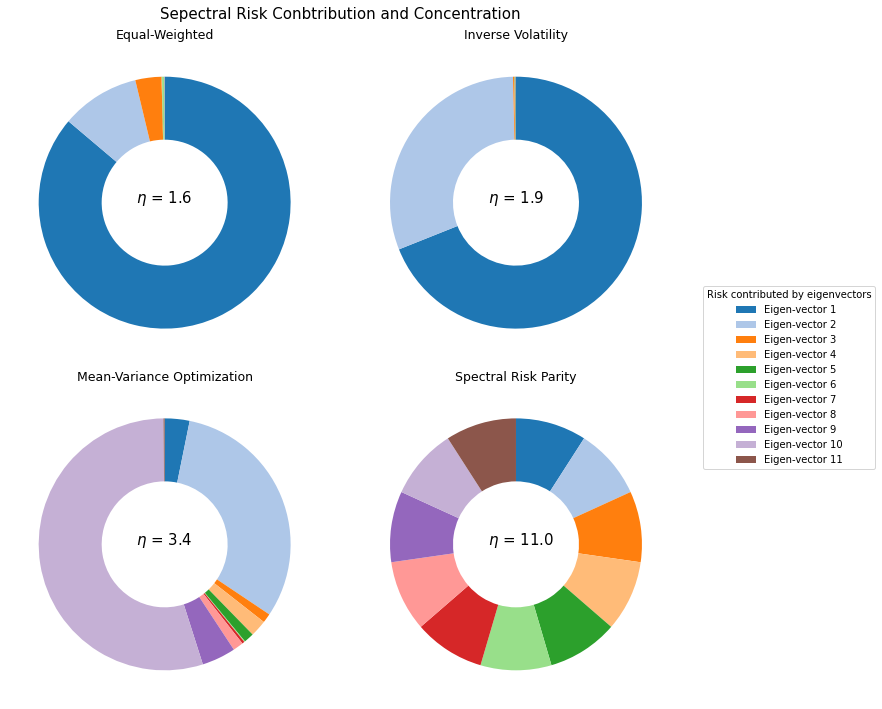

In [4]:
# Correlation matrix
Rho = excess_return.corr().values
S = np.diag(excess_return.std())

# We diagonalize Rho into its eigen-vector and eigen-value matrices
Lambda, V = np.linalg.eig(Rho)
order = Lambda.argsort()[::-1]
Lambda = np.diag(Lambda[order])
V = V[:, order]

# Spectral risk parity (SRP)
n = Lambda.shape[0]  # Number of elements
w_esrc = np.linalg.inv(S) @ V @ np.power(np.linalg.inv(Lambda), 1/2) @ np.ones(n).reshape(-1, 1)
w_esrc = w_esrc / w_esrc.sum()

# Benchmark methodologies
w_equally = np.array([1 / n] * n).reshape(-1, 1)
w_inversevol = (1 / np.diag(S)).reshape(-1, 1)
w_inversevol /= w_inversevol.sum()
Sigma = excess_return.cov().values
mu = excess_return.mean().values.reshape(-1, 1)
w_mvo = mu.T @ np.linalg.inv(Sigma)
w_mvo = (w_mvo / w_mvo.sum()).reshape(-1, 1)

# Calculate the diversification distribution vector (p_n) for each
p_equally = np.multiply(V.T @ S @ w_equally, Lambda @ V.T @ S @ w_equally) / (w_equally.T @ Sigma @ w_equally)
p_inversevol = np.multiply(V.T @ S @ w_inversevol, Lambda @ V.T @ S @ w_inversevol) / (w_inversevol.T @ Sigma @ w_inversevol)
p_mvo = np.multiply(V.T @ S @ w_mvo, Lambda @ V.T @ S @ w_mvo) / (w_mvo.T @ Sigma @ w_mvo)
p_esrc = (np.diag((V.T @ S @ w_esrc).flatten()) @ Lambda @ V.T @ S @ w_esrc) / (w_esrc.T @ S @ Rho @ S @ w_esrc)

# Finally we calculate the effective number of bets for each portfolio
enb_equally = np.exp(-np.sum(np.multiply(p_equally, np.log(p_equally))))
enb_inversevol = np.exp(-np.sum(np.multiply(p_inversevol, np.log(p_inversevol))))
enb_mvo = np.exp(-np.sum(np.multiply(p_mvo, np.log(p_mvo))))
enb_srp = np.exp(-np.sum(np.multiply(p_esrc, np.log(p_esrc))))

port_name = ['Equal-Weighted', 'Inverse Volatility', 'Mean-Variance Optimization', 'Spectral Risk Parity']
enb_all = dict(zip(port_name, [enb_equally, enb_inversevol, enb_mvo, enb_srp]))

# Let's visualize the results
theta = pd.DataFrame(np.concatenate([p_equally, p_inversevol, p_mvo, p_esrc], axis=1), columns=port_name, index=data_summary['Name'])
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

color_map = list(cm.get_cmap('tab20')(range(20))) + list(cm.get_cmap('Set3')(range(11)))
for i, loc in enumerate(itertools.product(range(2), range(2))):
    label = port_name[i]
    axs[loc].pie(
        theta[label], 
        normalize=True, 
        startangle=90, 
        counterclock=False, 
        wedgeprops=dict(width=0.5), 
        colors=color_map
    )
    axs[loc].set_title(label, fontsize=12.5)
    eta = round(enb_all[label], 1)
    axs[loc].annotate(f'$\eta$ = {eta}', xy=(-0.225, 0), fontsize=15)

fig.legend([f'Eigen-vector {x + 1}' for x in range(n)], bbox_to_anchor=(1.25, .6), ncol=1, title='Risk contributed by eigenvectors')
fig.suptitle('Sepectral Risk Conbtribution and Concentration', fontsize=15)
plt.tight_layout()
plt.show()

Using the entire sample for the parameter estimation, we can observe that the equal-weighted and Inverse Volatility portfolio construction methodologies result in very concentrated portfolios, which risk is mostly drive by the first eigen-vector. The previous is summarized by the effective number of bets, $\eta(w)$, which does not exceed 2. In terms of interpretability, this is equivalent to say that, despite investing in 11 securities, those two portfolios are equivalent to hold less than two independent bets. The case of the unconstrained Mean-Variance Optimization is slightly better, by leveraging the marginal Sharpe ratio of each asset (i.e., taking the covariances into account) it is able to increase the effective number of bets to slightly above 3. Even though this might sound as good news, we must remember that this is a purely in-sample and illustrative exercise. As it was expected, the linear transformation provided by the Spectral Risk Parity can provide that maximum diversification case were $\eta(w)=N$. 

As it can be seen below, both Mean-Variance Optimization and Spectral Risk Parity constructions are able to achieve higher diversification by introducing short-sells, which might not be always easily achievable in practice.

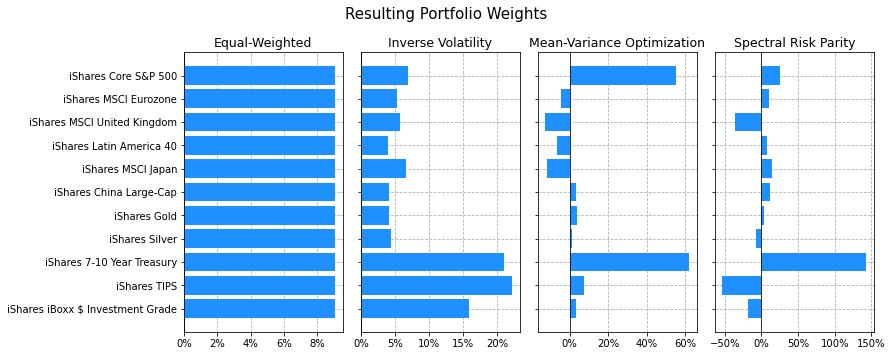

In [5]:
weights = pd.DataFrame(np.concatenate([w_equally, w_inversevol, w_mvo, w_esrc], axis=1), columns=port_name, index=data_summary['Name'])

colors = zip(port_name, ['royalblue']) 
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12.5, 5), sharey=True)
for i, loc in enumerate(range(4)):
    label = port_name[i]
    axs[loc].barh(
        width=weights[label].values[::-1], 
        y=range(weights.shape[0]), 
        zorder=100, 
        color='dodgerblue'
    )
    axs[loc].set_title(label, fontsize=12.5)
    axs[loc].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    axs[loc].grid(ls='--', zorder=-100)
    axs[loc].axvline(0, color='black', zorder=150, lw=.75)
    
axs[2].set_yticks(range(weights.shape[0]))
axs[2].set_yticklabels(data_summary['Name'][::-1])
axs[2].set_ylim(-1, weights.shape[0])
fig.suptitle('Resulting Portfolio Weights', fontsize=15)
plt.tight_layout()

## Part 3: Implementation
### 3.1 Challenges in the Implementation of SRP
The implementation of SRP is not free to challenges. Meucci et al. (2013) noted that, for a given risk model $\Sigma$, there are $2^{N-1}$ weights vectors that can yield the same level of diversification where $\eta(w)=N$. This is due to the fact that the sign of each eigen-vector is irrelevant when projecting these back into weights space. They suggest trying different combinations of eigen-vector signs based on different desired portfolio results, such as maximum Sharpe ratio and global minimum variance. Similarly, and for the sake of simplicity, we will select the set of eigen-vector signs that yields the portfolio with minimum volatility within the sets of $2^{N-1}$ possible portfolios. 

Furthermore we propose the formalization of the excercise as follows. The sets of portfolios $W_{N \times 2^{N-1}}$ that spans all the possible linear transformation that result in $\eta(w)=N$ is given by 

\begin{align}
W \propto S^{-1}E L^{-\frac{1}{2}}J
\end{align}

where 

\begin{align}
J = \begin{bmatrix} 
\mid & \mid &  & \mid \\ 
j_{1} & j_{2} & \dots & j_{2^{N-1}} \\
\mid & \mid &  & \mid \\ 
\end{bmatrix}_{N \times 2^{N-1}} 
\end{align}

and each $j_{i}$ is a vector with entries 1 and -1 that change the sign of each eigenvector, and together all $j$ span every possible combination of signs. Consequently, the portfolio variances will be given by the $2^{N-1}$ diagonal terms in 

$$
W^{T}\Sigma W
$$

Finally, we choose the $n$-th $j$ vector that generates then lowest diagonal entry in the expression above.

Other challenges, that include numerical issues in estimation of the eigenvectors and their stability, will not be studied in this simple implementation but will be addressed in future iterations.

### 3.2 Simplified Backtest
#### 3.2.1 Specification
The case-study seen in 2.3 was a completely in-sample exercise that had the objective of illustrating how the diversification measures are estimated. Now we can conduct a simple empirical analysis to simulate the historical performance of the SRP portfolio construction approach against other benchmark methodologies shown in 2.3. The specification of the backtest is the following:
- **Start date**: 12/31/2009
- **End date**: 2021/11/30
- **Data frequency**: Daily
- **Rebalance frequency**: Monthly (end of month)
- **Estimation window**: 2-year
- **Volatility target (Ex-ante)**: 10%
- **Transaction costs**: 0bp

**Notes**
1. The estimation window is updated on each rebalance, so there is no forward-looking bias
2. The volatility target is in place to make the results of the different portfolio construction methodologies directly comparable
3. The classes and functions used in this exercise are stored in **utils.py** located in this folder. Please refer to that file if more specific details are needed.

In [6]:
from utils import PortfolioRebalance, effective_bets

bt_start = datetime(2009, 12, 31)
bt_end = datetime(2021, 11, 30)
bt_window = pd.DateOffset(years=2)
bt_rebalance_freq = 'M'
rebalance_dates = pd.date_range(start=bt_start, end=bt_end, freq=bt_rebalance_freq)
vol_targeting = .1 * np.sqrt(1 / 252)
portfolio_labels = ['Equal-Weighted', 'Unconstrained Mean-Variance', 'Inverse Volatility', 'Spectral Risk Parity']

# Portfolio weights generation
weights_equalweights = pd.DataFrame(index=rebalance_dates, columns=excess_return.columns)
weights_inversevol = pd.DataFrame(index=rebalance_dates, columns=excess_return.columns)
weights_maxsharpe = pd.DataFrame(index=rebalance_dates, columns=excess_return.columns)
weights_spectral = pd.DataFrame(index=rebalance_dates, columns=excess_return.columns)
enb = pd.DataFrame(index=rebalance_dates, columns=portfolio_labels)
for dt in rebalance_dates:
    sample_t = excess_return.loc[dt - bt_window:dt]
    port = PortfolioRebalance(sample=sample_t, volatility_target=vol_targeting)
    # Equal-weight portfolio
    port.get_equalweight()
    weights_equalweights.loc[dt] = port.weights
    enb.loc[dt, portfolio_labels[0]] = effective_bets(weights=port.weights.values.reshape(-1, 1), cov=port.cov)

    # Maximum Sharpe ratio portfolio
    port.get_maxsharpe()
    weights_maxsharpe.loc[dt] = port.weights
    enb.loc[dt, portfolio_labels[1]] = effective_bets(weights=port.weights.values.reshape(-1, 1), cov=port.cov)

    # Inverse volatility portfolio
    port.get_inversevol()
    weights_inversevol.loc[dt] = port.weights
    enb.loc[dt, portfolio_labels[2]] = effective_bets(weights=port.weights.values.reshape(-1, 1), cov=port.cov)

    # Spectral risk parity portfolio
    port.get_spectral(criteria='MinVol')
    weights_spectral.loc[dt] = port.weights
    enb.loc[dt, portfolio_labels[3]] = effective_bets(weights=port.weights.values.reshape(-1, 1), cov=port.cov)

# Portfolio returns calculation
weekly_returns = excess_return.add(1).groupby(pd.Grouper(freq=bt_rebalance_freq)).prod().sub(1)
returns_equalweights = weights_equalweights.shift(1).mul(weekly_returns).reindex(rebalance_dates).sum(axis=1)
returns_maxsharpe = weights_maxsharpe.shift(1).mul(weekly_returns).reindex(rebalance_dates).sum(axis=1)
returns_inversevol = weights_inversevol.shift(1).mul(weekly_returns).reindex(rebalance_dates).sum(axis=1)
returns_spectral = weights_spectral.shift(1).mul(weekly_returns).reindex(rebalance_dates).sum(axis=1)

bt_results = pd.concat([returns_equalweights, returns_maxsharpe, returns_inversevol, returns_spectral], axis=1)
bt_results.columns = portfolio_labels
bt_results.iloc[0] = np.nan

#### 3.2.2 Results

In [7]:
bt_results_levels = bt_results.fillna(0).add(1).cumprod()
bt_dd = bt_results_levels.div(bt_results_levels.expanding().max()).sub(1)

# Stats
mu_ws = bt_results.add(1).prod().sub(1).mul(12 / bt_results.shape[0])
sigma_ws = bt_results.std().mul(np.sqrt(12))
sharpe_ratios = mu_ws / sigma_ws
max_dd = bt_dd.min()
res = pd.concat([mu_ws, sigma_ws, sharpe_ratios, max_dd], axis=1).round(2)
res.columns = ['Mean Excess-Return (Ann.)', 'Volatility (Ann.)', 'Sharpe Ratio', 'Max. Drawdown']
res

,Mean Excess-Return (Ann.),Volatility (Ann.),Sharpe Ratio,Max. Drawdown
Equal-Weighted,0.03,0.09,0.31,-0.19
Unconstrained Mean-Variance,0.20,0.11,1.71,-0.25
Inverse Volatility,0.07,0.10,0.74,-0.17
Spectral Risk Parity,0.23,0.10,2.25,-0.13


In the studied sample, Spectral Risk Parity was able to deliver the highest risk-adjusted return (given by the Sharpe ratio), while exhibiting the lowest maximum drawdown. As expected, the maximum drawdown delivered by the Unconstrained Mean-Variance were the maximum in the set of methodologies, given how noisy the ex-ante estimate of the expected return can be.

As it can be seen in the plots below, the delivered performance of the SRP construction methodology seems more stable over time. This also gets translated in drawdowns that rarely go beyond one standard deviation, as opposed to the other three methodologies. In terms of the effective number of bets, the portfolio construction methodologies that ignore the correlation structure (i.e., Equal-Weighted and Inverse Volatility) moves around 2, while the unconstrained Mean-Variance portfolios gave around between 3 and 6 effective independent bets over the sample. As expected, the SRP portfolio gave constant 11 independent bets during the exercise.

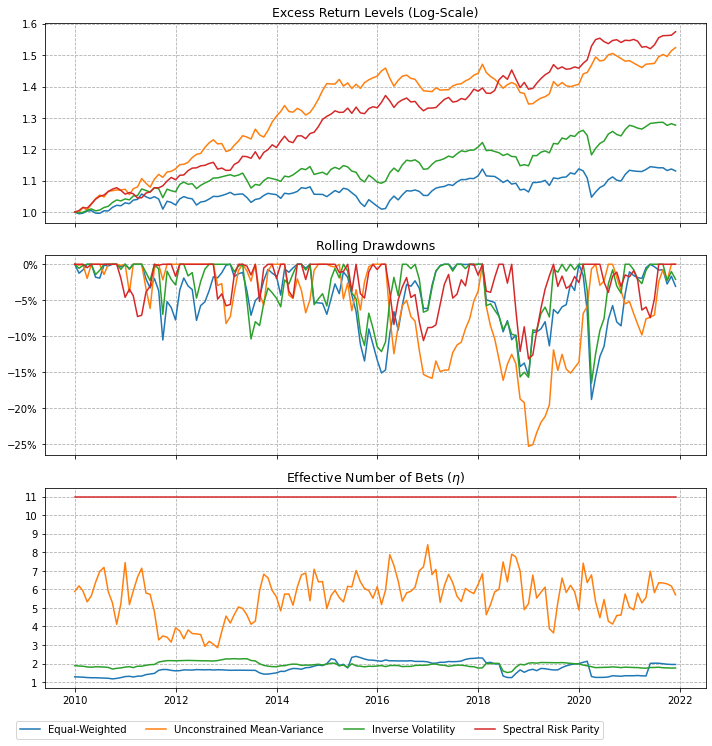

In [8]:
# Time-series plots
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10))
axs[0].plot(bt_results_levels.mul(10).apply(np.log10), zorder=100)
axs[1].plot(bt_dd, zorder=100)
axs[2].plot(enb, zorder=100)
titles = ['Excess Return Levels (Log-Scale)', 'Rolling Drawdowns', 'Effective Number of Bets ($\eta$)']
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
axs[2].set_yticks(range(1, excess_return.shape[1] + 1))
for i, ax in enumerate(axs):
    ax.set_title(titles[i], fontsize=12.5)
    ax.grid(ls='--', zorder=-100)
fig.legend(bt_results_levels.columns, bbox_to_anchor=(.85, 0), ncol=4)
fig.tight_layout()

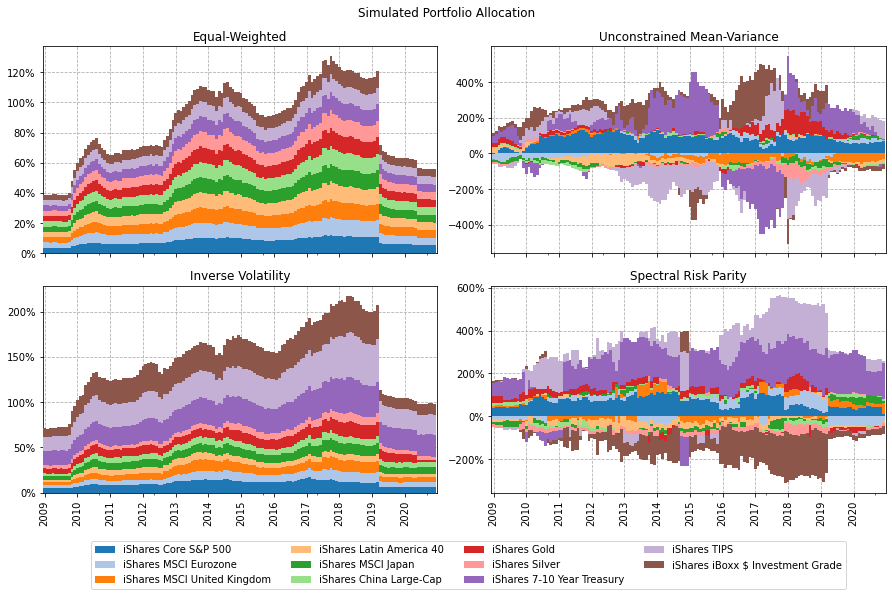

In [9]:
color_map = list(cm.get_cmap('tab20')(range(11)))
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12.5, 7.5))
fig.suptitle('Simulated Portfolio Allocation')
weights_equalweights.plot.bar(stacked=True, ax=axs[0, 0], width=1, color=color_map, legend=False, title=bt_results.columns[0], zorder=100)
weights_maxsharpe.plot.bar(stacked=True, ax=axs[0, 1], width=1, color=color_map, legend=False, title=bt_results.columns[1], zorder=100)
weights_inversevol.plot.bar(stacked=True, ax=axs[1, 0], width=1, color=color_map, legend=False, title=bt_results.columns[2], zorder=100)
weights_spectral.plot.bar(stacked=True, ax=axs[1, 1], width=1, color=color_map, legend=False, title=bt_results.columns[3], zorder=100)
year_end = [dt for dt in rebalance_dates if dt.month == 12]

for row in axs:
    for ax in row:
        ax.grid(ls='--', zorder=-100)
        ax.set_xticks([i for i, dt in enumerate(rebalance_dates) if dt.month == 12])
        ax.set_xticklabels([dt.strftime('%Y') for dt in year_end])
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

fig.tight_layout()
fig.legend(data_summary.reindex(weights_equalweights.columns)['Name'], bbox_to_anchor=(.95, 0), ncol=4)
plt.show()

### 3.3 Next steps
To expand on and deepen this analysis, the suggested research outline is:
1. Work out a way of achieving a more reliable and stable spectral decomposition to provide better results by introducing eigen-vector truncation or regularization (this would also speed up the calculation time), which would solve the $2^{N-1}$ problem of $J$ presented in **3.1**
2. Introduce leverage and short-selling constraints to increase the real-life applications of the methodology
3. Increase the size of the investible universe
4. Expand the spectrum of risk by including elements in $\Sigma$ beyond investible securities, to achieve a more diversified portfolio
5. Study how I can use the previous item, so the framework can also suggest which uninvested securities can be added to the portfolio to improve diversification
6. Explore the Singular Value Decomposition alternative to the eigen-decomposition to incorporate the time-series dimensionality of the data
7. Provide a more close-to-reality backtest, including more assets, real-life constraints, and transaction costs

<AxesSubplot:>

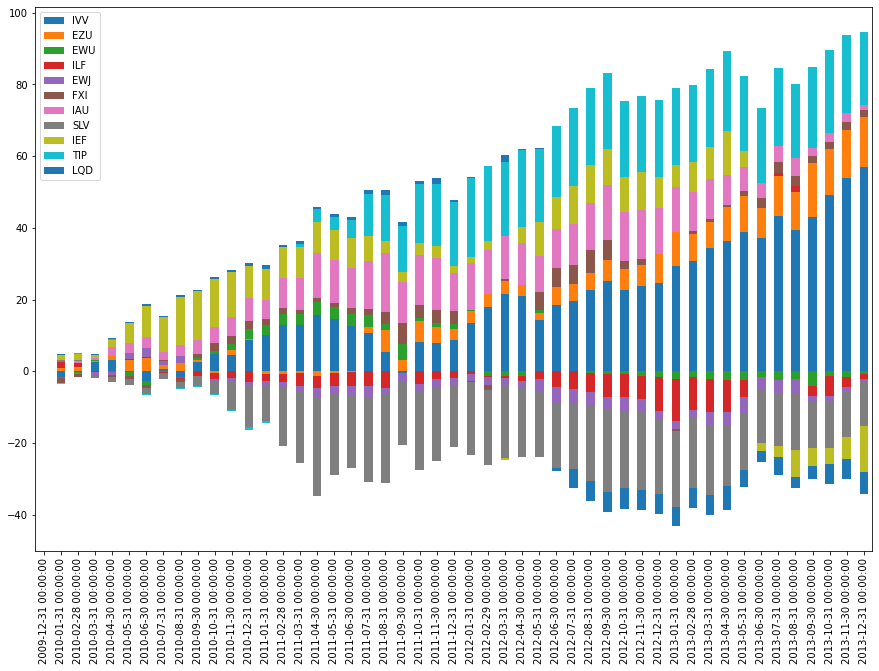

In [32]:
RxW = weights_spectral.shift(1).mul(weekly_returns).reindex(rebalance_dates)
nav = returns_spectral.add(1).cumprod().mul(100)
pnl = RxW.mul(nav.shift(1), axis=0)

fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 10))
pnl[:'2013'].cumsum().plot.bar(stacked=True, ax=axs)

<AxesSubplot:>

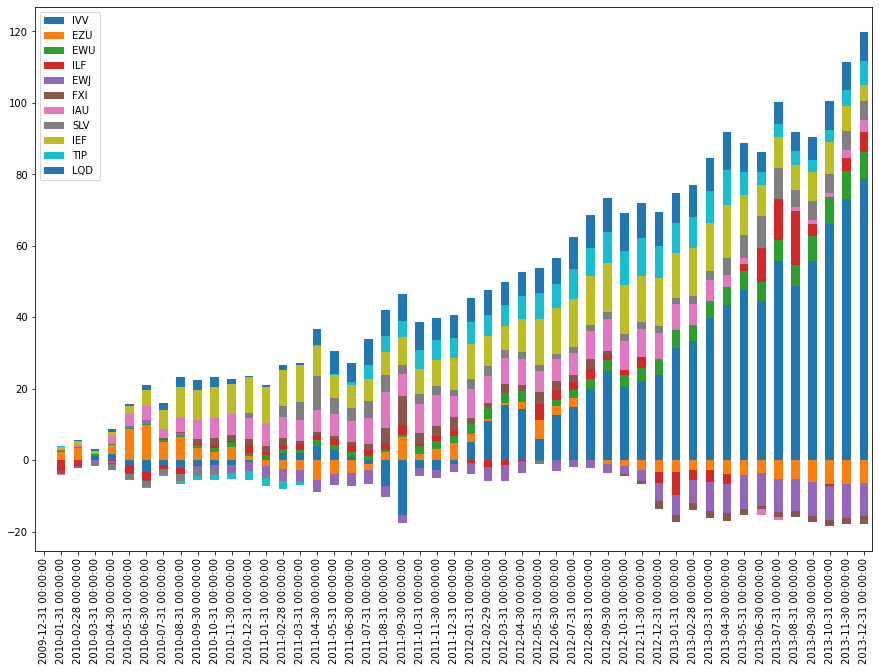

In [33]:
RxW = weights_maxsharpe.shift(1).mul(weekly_returns).reindex(rebalance_dates)
nav = returns_maxsharpe.add(1).cumprod().mul(100)
pnl = RxW.mul(nav.shift(1), axis=0)

fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 10))
pnl[:'2013'].cumsum().plot.bar(stacked=True, ax=axs)